# INTEG 475 - Introduction to Agent-Based Models 

The following tutorial is based off of Adil Moujahid's [Introduction to Agent-Based Models](https://www.binpress.com/tutorial/introduction-to-agentbased-models-an-implementation-of-schelling-model-in-python/144) - all quoted text is drawn therefrom.

## The Schelling Segregation Model

"If you look at the racial distribution of multi-ethnic cities, you'll be astonished by the incredible racial segregation. For example, the New York City map below represents data from the 2010 US Census color-coded by race. You can clearly see the racial segregation.

Many would conclude from such phenomena that people are intolerant, and don't want to live next to people that are different from them. A deeper look, however, might provide some nuance. In the 70's, Thomas Schelling, the 2005 Economics Nobel Prize winner, was interested in this subject and built an agent-based model called the "Schelling segregation model" for explaining this phenomenon. With a very simple model, Schelling could show that what we see at the macro level may not in fact represent what's going down in the micro level."

<img src='nyc.jpg'>

We're going to see if we can create a model which produces results similar to the map shown above, using the approach Schelling outlines in his Segregation Model.

Before we do anything else, we'll start by importing a few python packages we'll need to create the model. If you don't already have all of them installed, go do that now, using 'pip install PACKAGE_NAME' or 'conda install PACKAGE_NAME'. 


In [1]:
import matplotlib.pyplot as plt
import itertools
import random
import copy


Schelling's model is relatively simple: we start by defining a grid of $k$ width and $j$ length and popluate it with people from ethnic group 1, ethnic group 2, and empty houses in roughly equal measure. 

Each one of these agents occupies one house, and each house can only be occupied by one agent.

The model proceeds in 'steps' - that is, an arbitrary, discrete quanta of time passes every time the model is updated. The use of 'steps' as a quanta of time is discussed in detail in the Willensky and Rand textbook; the 'Evolution of Trust' game also uses a stepwise approach to time.  

Every time a step elapses, the Schelling model specifies that each agent carries out the following actions:

1. The agent determines its "Similarity Proportion" by observing what proportion of its orthogonal and diagonal neighbours belong to the same ethnic group that it does
2. The agent compares the proportion determined in step 1 to a predefined 'Similarity Threshold'
3. If the agent's "Similarity Proportion" is less than its "Similarity Threshold," the agent moves to a _randomly-determined_ empty house

Before we go any further, I'd like to emphasize that the agents' movement behaviours are random: when an agent decides to pack up and move, it does not select its new home based on the ethnic makeup of the new home's neighbourhod.  

This process gets repeated over a predetermined number of iterations (500 by default, in this tutorial). Once the simulation has ended, a final map is produced.

The following cells detail the process of building a version of this model in Python. Each portion of the final class will be presented here as a class of its own; the final class will inherit properties from each of them, creating the finished Schelling class.


This first class contains a function responsible for populating the simulation's grid with agents, and labelling all unused cells as 'empty houses.'

In [2]:
class POPULATE:
    
    def populate(self):
        self.all_houses = list(itertools.product(range(self.width),range(self.height)))
        random.shuffle(self.all_houses)

        self.n_empty = int( self.empty_ratio * len(self.all_houses) )
        self.empty_houses = self.all_houses[:self.n_empty]

        self.remaining_houses = self.all_houses[self.n_empty:]
        houses_by_race = [self.remaining_houses[i::self.races] for i in range(self.races)]
        for i in range(self.races):
            #create agents for each race
            self.agents = dict(
                                list(self.agents.items()) + 
                                list(dict(zip(houses_by_race[i], [i+1]*len(houses_by_race[i]))).items())
                            )

This next class implements two of the three stepwise agent behaviours: first, it determines each agent's 'similarity proportion, which it then compares to the agent's similarity threshold. 

As an input, it takes two positional arguments which locate the agent in the model's grid. It outputs a boolean value which is true if the agent is unsatisfied, and false if the agent is satsified. 

In [3]:
 class UNSATISFIED:
        
    def is_unsatisfied(self, x, y):

        race = self.agents[(x,y)]
        count_similar = 0
        count_different = 0

        if x > 0 and y > 0 and (x-1, y-1) not in self.empty_houses:
            if self.agents[(x-1, y-1)] == race:
                count_similar += 1
            else:
                count_different += 1
        if y > 0 and (x,y-1) not in self.empty_houses:
            if self.agents[(x,y-1)] == race:
                count_similar += 1
            else:
                count_different += 1
        if x < (self.width-1) and y > 0 and (x+1,y-1) not in self.empty_houses:
            if self.agents[(x+1,y-1)] == race:
                count_similar += 1
            else:
                count_different += 1
        if x > 0 and (x-1,y) not in self.empty_houses:
            if self.agents[(x-1,y)] == race:
                count_similar += 1
            else:
                count_different += 1        
        if x < (self.width-1) and (x+1,y) not in self.empty_houses:
            if self.agents[(x+1,y)] == race:
                count_similar += 1
            else:
                count_different += 1
        if x > 0 and y < (self.height-1) and (x-1,y+1) not in self.empty_houses:
            if self.agents[(x-1,y+1)] == race:
                count_similar += 1
            else:
                count_different += 1        
        if x > 0 and y < (self.height-1) and (x,y+1) not in self.empty_houses:
            if self.agents[(x,y+1)] == race:
                count_similar += 1
            else:
                count_different += 1        
        if x < (self.width-1) and y < (self.height-1) and (x+1,y+1) not in self.empty_houses:
            if self.agents[(x+1,y+1)] == race:
                count_similar += 1
            else:
                count_different += 1

        if (count_similar+count_different) == 0:
            return False
        else:
            return float(count_similar)/(count_similar+count_different) < self.similarity_threshold
        


The 'Update' class is responsible for iterating through each of the model's agents and feeding their position on the grid to the IS_UNSATISFIED class's only method. 

It is also responsible for determining which random empty house each unsatisfied agent will move to. 

In [4]:
class UPDATE:
    
    def update(self):
        for i in range(self.n_iterations):
            self.old_agents = copy.deepcopy(self.agents)
            n_changes = 0
            for agent in self.old_agents:
                if self.is_unsatisfied(agent[0], agent[1]):
                    agent_race = self.agents[agent]
                    empty_house = random.choice(self.empty_houses)
                    self.agents[empty_house] = agent_race
                    del self.agents[agent]
                    self.empty_houses.remove(empty_house)
                    self.empty_houses.append(agent)
                    n_changes += 1
            if n_changes == 0:
                break

The 'plot' class handles the process of visualizing the model's initial and final states. It currently allows for 7 different ethnic groups to be represented, but could be extended to allow for more. 

In [5]:
class PLOT:
    
    def plot(self, title):
        fig, ax = plt.subplots(facecolor="black", figsize=(8, 8))
        #If you want to run the simulation with more than 7 colors, you should set agent_colors accordingly
        agent_colors = {1:'b', 2:'r', 3:'g', 4:'c', 5:'m', 6:'y', 7:'k'}
        for agent in self.agents:
            ax.scatter(agent[0]+0.5, agent[1]+0.5, color=agent_colors[self.agents[agent]], marker = 'o')

        ax.set_title(title, fontsize=10, fontweight='bold', color='w')
        ax.set_xlim([0, self.width])
        ax.set_ylim([0, self.height])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_clip_on(False)
        ax.set_facecolor("lightgrey")
        plt.show()

Finally, the 'Schelling' class inherits methods from each of the preceding classes. It also contains an `__init__` method which feeds a number of global variables in as parameters for the model.

In [6]:
class Schelling(POPULATE, UNSATISFIED, UPDATE, PLOT):
    
    def __init__(self, width = 50, height = 50, empty_ratio = 0.3, similarity_threshold = 0.5, n_iterations = 100, races = 2):
        self.width = width 
        self.height = height 
        self.races = races
        self.empty_ratio = empty_ratio
        self.similarity_threshold = similarity_threshold
        self.n_iterations = n_iterations
        self.empty_houses = []
        self.agents = {}


## Control Panel

Feel free to play around with the definitions contained in the cell below: they control the parameters which are passed to our implementation of the Schelling Segregation Model.

__Note:__ there are three different "similarity threshold" values in the control panel; use graduated values to see how  increases or decreases in the agents' preferences for homogeneity impact the final output. 

In [7]:
width                  = 50
height                 = 50   
empty_ratio            = 0.3       
similarity_threshold_1 = 0.2
similarity_threshold_2 = 0.4
similarity_threshold_3 = 0.7
n_iterations           = 20         
races                  = 2           

In [8]:
schelling_initial = Schelling(width, height, empty_ratio, similarity_threshold_1, n_iterations, races)
schelling_initial.populate()

schelling_1 = Schelling(width, height, empty_ratio, similarity_threshold_1, n_iterations, races)
schelling_1.agents = copy.deepcopy(schelling_initial.agents)
schelling_1.empty_houses = copy.deepcopy(schelling_initial.empty_houses)

schelling_2 = Schelling(width, height, empty_ratio, similarity_threshold_2, n_iterations, races)
schelling_2.agents = copy.deepcopy(schelling_initial.agents)
schelling_2.empty_houses = copy.deepcopy(schelling_initial.empty_houses)

schelling_3 = Schelling(width, height, empty_ratio, similarity_threshold_3, n_iterations, races)
schelling_3.agents = copy.deepcopy(schelling_initial.agents)
schelling_3.empty_houses = copy.deepcopy(schelling_initial.empty_houses)

In [9]:
schelling_1.update()
schelling_2.update()
schelling_3.update()

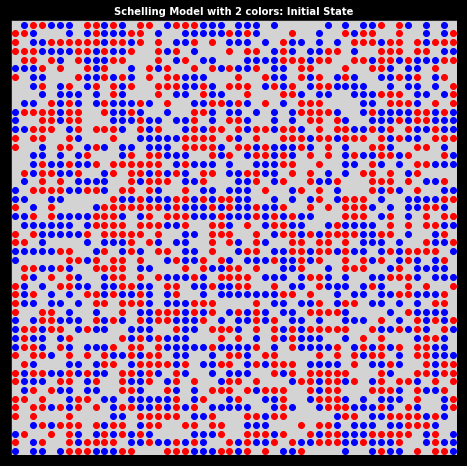

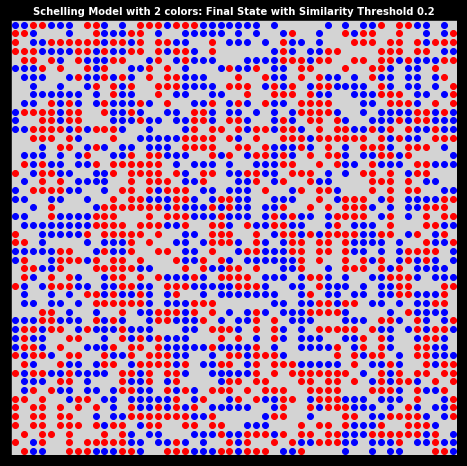

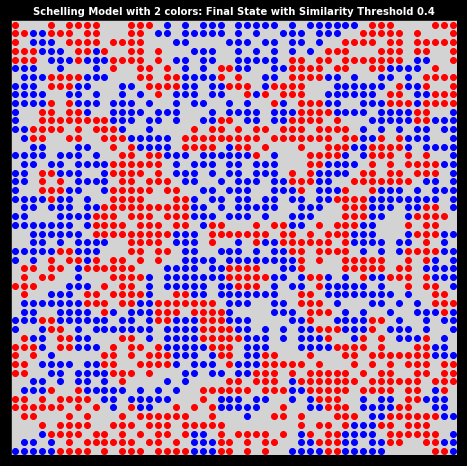

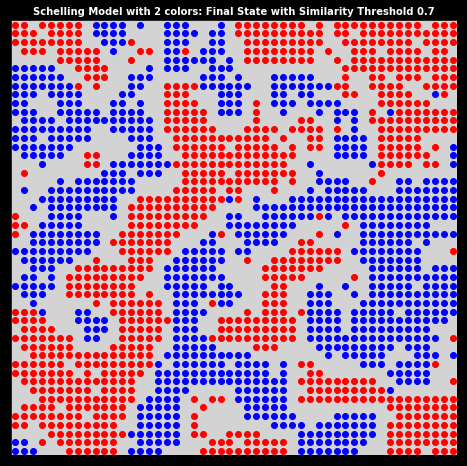

In [10]:
schelling_initial.plot('Schelling Model with ' + str(races) + ' colors: Initial State')
schelling_1.plot('Schelling Model with ' + str(races) + ' colors: Final State with Similarity Threshold ' + str(similarity_threshold_1))
schelling_2.plot('Schelling Model with ' + str(races) + ' colors: Final State with Similarity Threshold ' + str(similarity_threshold_2))
schelling_3.plot('Schelling Model with ' + str(races) + ' colors: Final State with Similarity Threshold ' + str(similarity_threshold_3))